# Investigating Directories

In [1]:
import os

# Directory paths
data_dir = "C:/Users/prati/Downloads/archive/train"

# Listing the directories within the main directory
main_directory_contents = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Listing the subdirectories within each directory in the main directory
subdirectory_contents = {}
for subdir in main_directory_contents:
    subdir_path = os.path.join(data_dir, subdir)
    subdirs = [d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))]
    if subdirs:
        subdirectory_contents[subdir] = subdirs

main_directory_contents

['good', 'scratch', 'stain']

# Hybrid Model --> ResNet, VGG16, MobileNetV3Small

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV3Small, ResNet50
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# Ensure TensorFlow is using the GPU and configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


# Directory paths
data_dir = "C:/Users/prati/Downloads/archive/train"

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    horizontal_flip=True,
    fill_mode="nearest"
)

BATCH_SIZE = 64

train_generator_original = datagen.flow_from_directory(
    data_dir,
    target_size=(192, 108),
    classes=['good','scratch', 'stain'],
    batch_size=BATCH_SIZE,
    subset='training'
)

validation_generator_original = datagen.flow_from_directory(
    data_dir,
    target_size=(192, 108),
    classes=['good','scratch', 'stain'],
    batch_size=BATCH_SIZE,
    subset='validation'
)

def custom_generator(original_generator):
    while True:
        data, labels = next(original_generator)
        yield [data, data, data], labels

train_generator = custom_generator(train_generator_original)
validation_generator = custom_generator(validation_generator_original)

# Load VGG16, MobileNetV3Small, and ResNet50 models
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(192, 108, 3)))
base_model_mobilenet = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=Input(shape=(192, 108, 3)))
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(192, 108, 3)))

# Freeze the layers of all models
for model in [base_model_vgg, base_model_mobilenet, base_model_resnet]:
    for layer in model.layers[:-4]:  # Unfreeze the last 4 layers for fine-tuning
        layer.trainable = False

# Extract features using all models
features_vgg = base_model_vgg.output
features_mobilenet = base_model_mobilenet.output
features_resnet = base_model_resnet.output

# Flatten and concatenate the features
features_vgg = Flatten()(features_vgg)
features_mobilenet = Flatten()(features_mobilenet)
features_resnet = Flatten()(features_resnet)
concatenated_features = Concatenate()([features_vgg, features_mobilenet, features_resnet])

# Add dense layers followed by dropout with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated_features)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Define the hybrid model
model = Model(inputs=[base_model_vgg.input, base_model_mobilenet.input, base_model_resnet.input], outputs=predictions)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint("C:/Users/prati/Downloads/archive/best_model.h5", monitor="val_accuracy", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the hybrid model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    steps_per_epoch=train_generator_original.samples // BATCH_SIZE,
    validation_steps=validation_generator_original.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator_original.samples // BATCH_SIZE)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


Found 3412 images belonging to 3 classes.
Found 851 images belonging to 3 classes.


Epoch 1/15


53/53 [==============================] - ETA: 0s - loss: 10.5872 - accuracy: 0.6011

C:\Users\prati\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 244s 4s/step - loss: 10.5872 - accuracy: 0.6011 - val_loss: 7.1530 - val_accuracy: 0.7584 - lr: 9.9454e-05
Epoch 2/15
53/53 [==============================] - 200s 4s/step - loss: 6.0075 - accuracy: 0.8447 - val_loss: 5.3104 - val_accuracy: 0.8501 - lr: 9.8900e-05
Epoch 3/15
53/53 [==============================] - 203s 4s/step - loss: 4.7833 - accuracy: 0.8859 - val_loss: 4.4662 - val_accuracy: 0.8717 - lr: 9.8349e-05
Epoch 4/15
53/53 [==============================] - 207s 4s/step - loss: 4.0895 - accuracy: 0.9059 - val_loss: 3.8283 - val_accuracy: 0.9250 - lr: 9.7801e-05
Epoch 5/15
53/53 [==============================] - 210s 4s/step - loss: 3.5698 - accuracy: 0.9197 - val_loss: 3.3439 - val_accuracy: 0.9314 - lr: 9.7257e-05
Epoch 6/15
53/53 [==============================] - 229s 4s/step - loss: 3.1065 - accuracy: 0.9492 - val_loss: 3.0178 - val_accuracy: 0.9250 - lr: 9.6715e-05
Epoch 7/15
53/53 [==============================] - 203s 4s/st

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load the trained model
model = tf.keras.models.load_model("C:/Users/prati/Downloads/archive/best_model.h5")

def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(192, 108))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input shape
    
    # Make a prediction
    predictions = model.predict([img_array, img_array, img_array])  # As the model has 3 inputs
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class index to the respective class
    class_map = ['good','scratch', 'stain']
    return class_map[predicted_class[0]]

# Test with a set of provided images
image_directory = "C:/Users/prati/Downloads/archive/test2"
class_folders = os.listdir(image_directory)

correct_predictions = 0
wrong_predictions = 0
total_images = 493

for class_folder in class_folders:
    class_path = os.path.join(image_directory, class_folder)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            prediction = predict_image(img_path)
            
            print(f"Image: {img_file}, Predicted Class: {prediction}, Actual Class: {class_folder}")
            
            if prediction == class_folder:
                correct_predictions += 1
            else:
                wrong_predictions += 1

            
            

accuracy = max(0, min(correct_predictions / total_images * 100, 100))
print(f"Accuracy: {accuracy:.2f}%")
print(f"Number of wrongly predicted images: {wrong_predictions}")

1/1 [==============================] - 3s 3s/step
Image: digital-device-mockup_53876-89919 - Copy (2) - Copy.jpg, Predicted Class: good, Actual Class: good
1/1 [==============================] - 0s 194ms/step
Image: digital-device-mockup_53876-89919 - Copy (2).jpg, Predicted Class: good, Actual Class: good
1/1 [==============================] - 0s 172ms/step
Image: digital-device-mockup_53876-89919 - Copy (3).jpg, Predicted Class: good, Actual Class: good
1/1 [==============================] - 0s 199ms/step
Image: digital-device-mockup_53876-89919 - Copy - Copy (2).jpg, Predicted Class: good, Actual Class: good
1/1 [==============================] - 0s 166ms/step
Image: digital-device-mockup_53876-89919 - Copy - Copy - Copy.jpg, Predicted Class: good, Actual Class: good
1/1 [==============================] - 0s 197ms/step
Image: digital-device-mockup_53876-89919 - Copy - Copy.jpg, Predicted Class: good, Actual Class: good
1/1 [==============================] - 0s 173ms/step
Image: digi

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load the trained model
model = tf.keras.models.load_model("C:/Users/prati/Downloads/archive/best_model.h5")

def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(192, 108,3))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input shape
    
    # Make a prediction
    predictions = model.predict([img_array,img_array,img_array])  # As the model has 3 inputs
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class index to the respective class
    class_map = ['good','scratch','stain']
    return class_map[predicted_class[0]]

# Test with a set of provided images
image_directory = "C:/Users/prati/Downloads/archive/test2"
image_files = os.listdir(image_directory)



for img_file in image_files:
    img_path = os.path.join(image_directory, img_file)
    prediction = predict_image(img_path)
    print(f"Image: {img_file}, Predicted Class: {prediction}")

1/1 [==============================] - 2s 2s/step
Image: test.jpg, Predicted Class: scratch


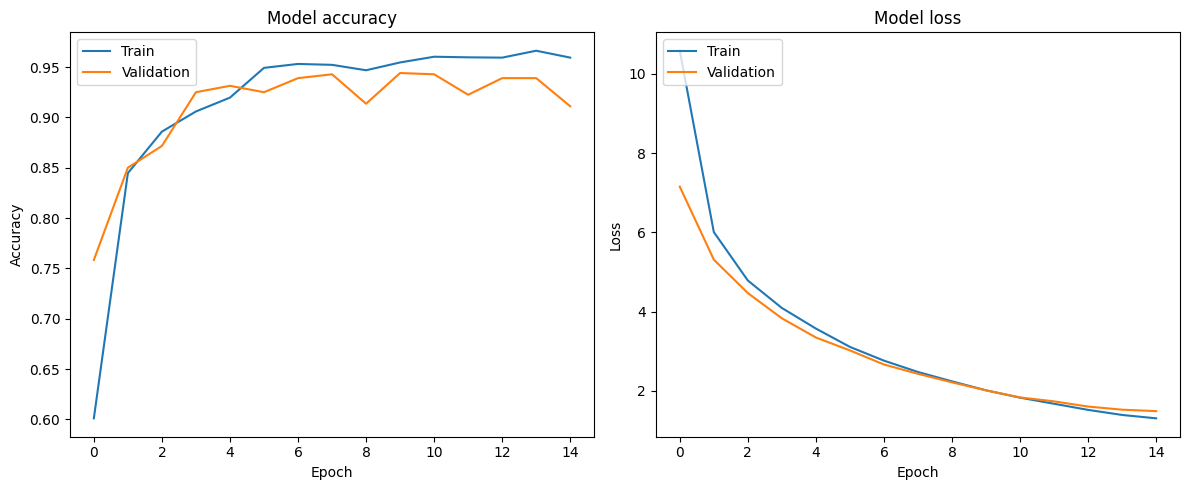

In [3]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

Updated

With GUI


1/1 [==============================] - 0s 209ms/step


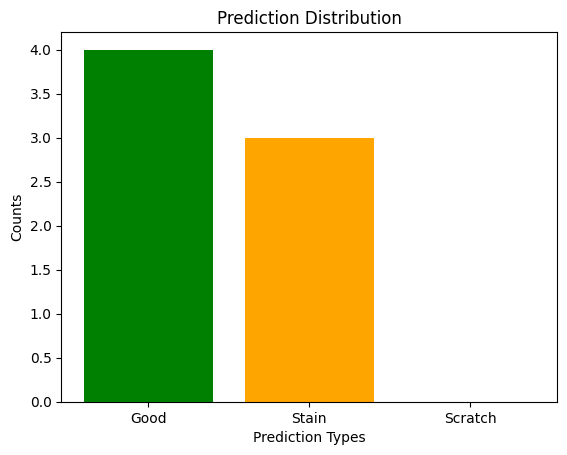

In [1]:
import tkinter as tk
from tkinter import ttk  # Import themed Tkinter module
from PIL import Image, ImageTk
import cv2
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import time
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from fpdf import FPDF
import os
from tkinter import messagebox

# Load the trained model
model = tf.keras.models.load_model("best_model.h5")

# Load the MobileNetV2 model for object detection from TensorFlow Hub
object_detection_model = hub.load("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/ssd-mobilenet-v2/versions/1")

# Initialize Firebase
cred = credentials.Certificate(r"C:/Users/prati/Downloads/defect-detection-d80c2-firebase-adminsdk-wcxyl-5d6ef4366f.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

def open_defect_scanner():
    # Close the current window
    window.destroy()

    # Create and open the Defect Scanner window
    root = tk.Tk()
    app = ImagePredictorGUI(root)
    root.mainloop()

def scan():
    open_defect_scanner()

def detect_and_crop(frame):
    # Convert the frame to RGB for object detection
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform object detection
    results = object_detection_model(frame_rgb[np.newaxis, ...])

    # Parse the results
    result = {key: value[0].numpy() for key, value in results.items()}
    boxes = result["detection_boxes"]
    scores = result["detection_scores"]
    classes = result["detection_classes"]

    # Get bounding box coordinates of detected phone (class label 77 for mobile phone in COCO dataset)
    detected_boxes = []
    for i in range(len(boxes)):
        if classes[i] == 77 and scores[i] > 0.5:  # Assuming 0.5 as the threshold for detection confidence
            detected_boxes.append(boxes[i])

    return detected_boxes

class ImagePredictorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Mobile Phone Detector")
        self.root.geometry("1200x600")

        self.image_label = tk.Label(root)
        self.image_label.pack(side="left", padx=10, pady=10)

        self.result_label = tk.Label(root, text="")
        self.result_label.pack(side="top", pady=10)

        self.detected_image_label = tk.Label(root)
        self.detected_image_label.pack(side="top", padx=10, pady=10)

        # Create a Label for displaying predictions with vertical scrollbar
        self.results_label = tk.Label(root, text="Predictions:")
        self.results_label.pack(side="top", padx=10, pady=10)

        # Create a Text widget for displaying predictions with vertical scrollbar
        self.results_text = tk.Text(root, wrap="word", height=25, width=50)
        self.results_text.pack(side="bottom", padx=10, pady=10, expand=False)

        # Create a vertical scrollbar
        self.scrollbar = tk.Scrollbar(root, command=self.results_text.yview)
        self.scrollbar.pack(side="right", fill="y")

        # Connect the scrollbar to the Text widget
        self.results_text.config(yscrollcommand=self.scrollbar.set)

        # Initialize camera
        self.camera = None

        # Initialize object detection
        self.init_camera()

        # Initialize timestamp for result display interval
        self.last_detection_time = 0

        # Store indexed results
        self.results = []
        self.result_index = 1

        # Store reference to the document in Firestore
        self.document_ref = None

        # Store reference to PhotoImage objects
        self.photo_img = None
        self.segmented_img = None

        # Generate document name based on current date and time at the start of the program
        self.document_name = datetime.now().strftime("%Y-%m-%d %H-%M")
        self.document_ref = db.collection("DetectedDefects").document(self.document_name)

        # Bind the close event to the on_closing method
        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)

    def on_closing(self):
        if messagebox.askokcancel("Quit", "Do you want to Download Report?"):
            self.release_resources()
            self.generate_bar_graph()
            self.generate_pdf()
            self.root.destroy()

    def release_resources(self):
        # Release camera and destroy the GUI when closed
        if self.camera:
            self.camera.release()

    def init_camera(self):
        # Initialize the camera
        self.release_camera()  # Release any existing camera
        self.camera = cv2.VideoCapture(0)  # 0 corresponds to the default camera
        self.update()

    def release_camera(self):
        # Release the camera
        if self.camera:
            self.camera.release()

    def update(self):
        if self.camera:
            ret, frame = self.camera.read()
            if ret:
                # Perform object detection and draw bounding box
                detected_boxes = detect_and_crop(frame)
                current_time = time.time()  # Current time

                h, w, _ = frame.shape  # Define h and w here

                if detected_boxes:
                    if current_time - self.last_detection_time >= 5:
                        # Only update result if 5 seconds have passed since the last detection
                        self.last_detection_time = current_time  # Update last detection time

                        # Draw bounding boxes on the frame
                        for box in detected_boxes:
                            ymin, xmin, ymax, xmax = box
                            x, y, w, h = int(xmin * w), int(ymin * h), int((xmax - xmin) * w), int((ymax - ymin) * h)
                            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw a green rectangle

                            # Extract the region of interest (ROI) for classification
                            roi = frame[y:y + h, x:x + w]
                            processed_image = cv2.resize(roi, (108, 192)) / 255.0  # Resize and normalize image

                            # Prepare three input tensors for the model
                            processed_image_input = np.expand_dims(processed_image, axis=0)  # Add batch dimension
                            inputs = [processed_image_input] * 3  # Repeat the same input three times

                            # Make prediction
                            predictions = model.predict(inputs)
                            prediction = np.argmax(predictions[0])  # Assuming the same prediction for all inputs

                            # Display the result
                            if prediction == 0:
                                result_text = "Phone is scratched"
                                defect = 'Scratch'
                            elif prediction == 1:
                                result_text = "Phone is stained"
                                defect = 'Stained'
                            else:
                                result_text = "Phone is good"
                                defect = 'Good'

                            # Update result label
                            self.result_label.config(text=result_text)

                            # Update indexed results
                            self.results.append((self.result_index, result_text))
                            self.update_results_text()  # Call the method to update the Text widget
                            self.result_index += 1

                            # Store detected defects in Firestore
                            self.update_firestore()

                            # Segment the image and highlight non-plain parts
                            # For illustration purpose, you can replace this with your segmentation algorithm
                            segmented_image = cv2.cvtColor(cv2.Canny(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), 30, 150), cv2.COLOR_GRAY2BGR)

                            # Convert segmented image to binary
                            segmented_image_binary = cv2.threshold(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)[1]

                            # Display the segmented image
                            segmented_image_binary_rgb = cv2.cvtColor(segmented_image_binary, cv2.COLOR_GRAY2RGB)
                            segmented_image_binary_pil = Image.fromarray(segmented_image_binary_rgb)
                            self.segmented_img = ImageTk.PhotoImage(segmented_image_binary_pil)
                            self.detected_image_label.config(image=self.segmented_img)

                else:
                    # No mobile phone detected
                    self.result_label.config(text="No mobile phone detected")
                    self.last_detection_time = current_time  # Update last detection time

                # Display the frame with bounding boxes
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                self.photo_img = ImageTk.PhotoImage(Image.fromarray(frame_rgb))
                self.image_label.config(image=self.photo_img)

        self.root.after(10, self.update)  # Update every 10 milliseconds

    def update_results_text(self):
        # Update the Text widget with the latest predictions
        indexed_results_text = "\n".join([f"{index}: {result}" for index, result in self.results])
        self.results_text.config(state=tk.NORMAL)  # Enable editing
        self.results_text.delete("1.0", tk.END)  # Clear previous content
        self.results_text.insert(tk.END, indexed_results_text)  # Insert new content
        self.results_text.config(state=tk.DISABLED)  # Disable editing

    def update_firestore(self):
        # Flatten the list of tuples into a single list of strings with timestamp
        flat_results = [f"{index}: {result} - {datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}" for index, result in self.results]
        data = {"predictions": flat_results}

        # Set the data in the document created at the start of the program
        self.document_ref.set(data)

    def generate_bar_graph(self):
        # Count occurrences of each prediction type
        prediction_counts = {"Good": 0, "Stain": 0, "Scratch": 0}
        for _, prediction_text in self.results:
            if prediction_text == "Phone is good":
                prediction_counts["Good"] += 1
            elif prediction_text == "Phone is stained":
                prediction_counts["Stain"] += 1
            elif prediction_text == "Phone is scratched":
                prediction_counts["Scratch"] += 1

        # Generate bar graph
        prediction_types = list(prediction_counts.keys())
        counts = list(prediction_counts.values())

        plt.bar(prediction_types, counts, color=['green', 'orange', 'red'])
        plt.xlabel('Prediction Types')
        plt.ylabel('Counts')
        plt.title('Prediction Distribution')
        plt.savefig('prediction_distribution.png')  # Save the plot as an image

    def generate_pdf(self):
        # Create PDF document
        pdf = FPDF()
        pdf.add_page()

        # Add title
        pdf.set_font("Arial", size=16, style='B')
        pdf.cell(200, 10, txt="Prediction Report", ln=True, align="C")
        pdf.cell(200, 10, txt="", ln=True, align="C")  # Add empty line

        # Add prediction table
        pdf.set_font("Arial", size=12, style='B')
        pdf.cell(30, 10, "Index", 1, 0, "C")
        pdf.cell(80, 10, "Prediction", 1, 0, "C")
        pdf.cell(80, 10, "Time", 1, 1, "C")

        # Add prediction data
        pdf.set_font("Arial", size=12)
        for index, (prediction_index, prediction_text) in enumerate(self.results, 1):
            pdf.cell(30, 10, str(index), 1, 0, "C")
            pdf.cell(80, 10, prediction_text, 1, 0, "C")
            pdf.cell(80, 10, datetime.now().strftime(
                '%Y-%m-%d %H:%M:%S'), 1, 1, "C")

        # Add empty line with larger height for gap
        pdf.cell(200, 25, txt="", ln=True, align="C")

        # Add boundary box for figures
        pdf.set_line_width(0.5)
        pdf.rect(10, pdf.get_y()+10, 90, 90)  # Boundary box for bar graph
        pdf.rect(110, pdf.get_y()+10, 90, 90)  # Boundary box for pie chart

        # Add bar graph title
        pdf.set_font("Arial", size=14, style='B')
        pdf.cell(10, 10, txt="Prediction Distribution", ln=True, align="L")
        # Add empty line with smaller height
        pdf.cell(200, 5, txt="", ln=True, align="C")

        # Generate bar graph
        prediction_counts = {"Good": 0, "Stain": 0, "Scratch": 0}
        for _, prediction_text in self.results:
            if prediction_text == "Phone is good":
                prediction_counts["Good"] += 1
            elif prediction_text == "Phone is stained":
                prediction_counts["Stain"] += 1
            elif prediction_text == "Phone is scratched":
                prediction_counts["Scratch"] += 1

        prediction_types = list(prediction_counts.keys())
        counts = list(prediction_counts.values())

        plt.figure(figsize=(5, 4))  # Adjusted figure size
        plt.bar(prediction_types, counts, color=['green', 'orange', 'red'])
        plt.xlabel('Prediction Types')
        plt.ylabel('Counts')
        plt.title('Prediction Distribution')
        plt.savefig('prediction_distribution.png')  # Save the plot as an image
        plt.close()

        # Add the bar graph
        pdf.image('prediction_distribution.png', x=15,
              y=pdf.get_y()+10, w=80, h=60, type='', link='')

        # Add pie chart title
        pdf.set_font("Arial", size=14, style='B')
        #pdf.cell(155, 10, txt="Prediction Percentage", ln=True, align="R")
        # Add empty line with smaller height
        pdf.cell(200, 5, txt="", ln=True, align="C")

        # Generate pie chart
        prediction_percentages = [100 * count /
                              len(self.results) for count in counts]

        plt.figure(figsize=(5, 4))  # Adjusted figure size
        plt.pie(prediction_percentages, labels=prediction_types,
                autopct='%1.1f%%', startangle=90)
        # Equal aspect ratio ensures that pie is drawn as a circle
        plt.axis('equal')
        plt.title('Prediction Percentage')
        
        plt.savefig('prediction_percentage.png')
        plt.close()

        # Add the pie chart
        pdf.image('prediction_percentage.png', x=115,
                  y=pdf.get_y() , w=80, h=55, type='', link='')

        # Save the PDF
        pdf_file_name = f"predictions_{self.document_name}.pdf"
        pdf.output(pdf_file_name)

        # Clean up - delete the image files used for the plots
        os.remove('prediction_distribution.png')
        os.remove('prediction_percentage.png')


# Main window
window = tk.Tk()
window.title("Defect Scanner")
window.geometry("1200x600")
window.resizable(False, False)
window.config(bg="#2086b7")

canvas1 = tk.Canvas(window, width=1200, height=600, bg="#00a2e8")
canvas1.pack(fill= 'both')

background1 = tk.Frame(canvas1, bg="#00a2e8")
background1.place(x=0, y=0, width=600, height=600)

background2 = tk.Frame(canvas1, bg="white")
background2.place(x=600, y=0, width=600, height=600)




helloTxt = tk.Label(window, text="Hello there!", bg="white", font=("Nunito", 16))
helloTxt.place(x=875, y=50)

l1 = tk.Label(window, text="Welcome to Scanner,", bg="#00a2e8", fg="WHITE", font=("Nunito bold", 18))
l2 = tk.Label(window, text="The ultimate AI assisted Defect Detection app.", font=("Nunito", 14), bg="#00a2e8",
              fg="WHITE")

l1.place(x=200, y=250)
l2.place(x=120, y=280)

# Use ttk.Button for a more visually appealing button
scan_Btn = ttk.Button(window, text="Scan", style='TButton', command=scan)
scan_Btn.place(x=850, y=260)

# Create a style for the themed button
style = ttk.Style()
style.configure('TButton', font=('Nunito', 16))

window.mainloop()


Experiment (Working)

1/1 [==============================] - 0s 135ms/step


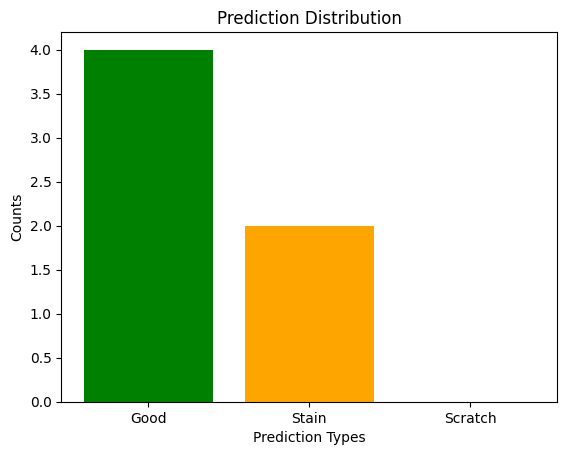

In [1]:
import tkinter as tk
from tkinter import ttk  # Import themed Tkinter module
from PIL import Image, ImageTk
import cv2
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import time
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from fpdf import FPDF
import os
from tkinter import messagebox

# Load the trained model
model = tf.keras.models.load_model("best_model.h5")

# Load the MobileNetV2 model for object detection from TensorFlow Hub
object_detection_model = hub.load("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/ssd-mobilenet-v2/versions/1")

# Initialize Firebase
cred = credentials.Certificate(r"C:/Users/prati/Downloads/defect-detection-d80c2-firebase-adminsdk-wcxyl-5d6ef4366f.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

def open_defect_scanner():
    # Close the current window
    window.destroy()

    # Create and open the Defect Scanner window
    root = tk.Tk()
    app = ImagePredictorGUI(root)
    root.mainloop()

def scan():
    open_defect_scanner()

def detect_and_crop(frame):
    # Convert the frame to RGB for object detection
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform object detection
    results = object_detection_model(frame_rgb[np.newaxis, ...])

    # Parse the results
    result = {key: value[0].numpy() for key, value in results.items()}
    boxes = result["detection_boxes"]
    scores = result["detection_scores"]
    classes = result["detection_classes"]

    # Get bounding box coordinates of detected phone (class label 77 for mobile phone in COCO dataset)
    detected_boxes = []
    for i in range(len(boxes)):
        if classes[i] == 77 and scores[i] > 0.5:  # Assuming 0.5 as the threshold for detection confidence
            detected_boxes.append(boxes[i])

    return detected_boxes

class ImagePredictorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Mobile Phone Detector")
        self.root.geometry("1200x600")

        self.image_label = tk.Label(root)
        self.image_label.pack(side="left", padx=10, pady=10)

        self.result_label = tk.Label(root, text="")
        self.result_label.pack(side="top", pady=10)

        self.detected_image_label = tk.Label(root)
        self.detected_image_label.pack(side="top", padx=10, pady=10)

        button_frame = tk.Frame(root)
        button_frame.pack(side="bottom", fill="x", padx=10, pady=10)

        # Add button for generating report
        self.generate_report_button = ttk.Button(button_frame, text="Generate Report", style='TButton', command=self.generate_and_close)
        self.generate_report_button.pack(side="right", padx=10, pady=(0, 10))  # Align to the right side of the button_frame with some padding

        # Create a frame for the predictions
        predictions_frame = tk.Frame(root)
        predictions_frame.pack(side="bottom", fill="both", padx=10, pady=(10, 0), expand=True)

        # Create a Label for displaying predictions with vertical scrollbar
        self.results_label = tk.Label(predictions_frame, text="Predictions:")
        self.results_label.pack(side="top", padx=10, pady=10)

        # Create a Text widget for displaying predictions with vertical scrollbar
        self.results_text = tk.Text(predictions_frame, wrap="word", height=25, width=50)
        self.results_text.pack(side="bottom", padx=10, pady=10, expand=True)

        # Create a vertical scrollbar
        self.scrollbar = tk.Scrollbar(predictions_frame, command=self.results_text.yview)
        self.scrollbar.pack(side="right", fill="y")

        # Connect the scrollbar to the Text widget
        self.results_text.config(yscrollcommand=self.scrollbar.set)

        # Initialize camera
        self.camera = None

        # Initialize object detection
        self.init_camera()

        # Initialize timestamp for result display interval
        self.last_detection_time = 0

        # Store indexed results
        self.results = []
        self.result_index = 1

        # Store reference to the document in Firestore
        self.document_ref = None

        # Store reference to PhotoImage objects
        self.photo_img = None
        self.segmented_img = None

        # Generate document name based on current date and time at the start of the program
        self.document_name = datetime.now().strftime("%Y-%m-%d %H-%M")
        self.document_ref = db.collection("DetectedDefects").document(self.document_name)

        # Bind the close event to the on_closing method
        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)

        '''button_frame = tk.Frame(root)
        button_frame.pack(side="top", fill="x", padx=10, pady=10, anchor="e")  # Align to the top right corner

        self.generate_report_button = ttk.Button(root, text="Generate Report", style='TButton', command=self.generate_and_close)
        self.generate_report_button.pack(side="right", padx=(0, 10))  # Align to the right side of the button_frame with some padding'''


    def generate_and_close(self):
        # Generate the report
        self.generate_bar_graph()
        self.generate_pdf()

        # Close the window
        if messagebox.askokcancel("Quit", "Do you want to Download Report?"):
            self.release_resources()
            self.root.destroy()

    def on_closing(self):
        if messagebox.askokcancel("Quit", "Do you want to Download Report?"):
            self.release_resources()
            self.generate_bar_graph()
            self.generate_pdf()
            self.root.destroy()

    def release_resources(self):
        # Release camera and destroy the GUI when closed
        if self.camera:
            self.camera.release()

    def init_camera(self):
        # Initialize the camera
        self.release_camera()  # Release any existing camera
        self.camera = cv2.VideoCapture(0)  # 0 corresponds to the default camera
        self.update()

    def release_camera(self):
        # Release the camera
        if self.camera:
            self.camera.release()

    def update(self):
        if self.camera:
            ret, frame = self.camera.read()
            if ret:
                # Perform object detection and draw bounding box
                detected_boxes = detect_and_crop(frame)
                current_time = time.time()  # Current time

                h, w, _ = frame.shape  # Define h and w here

                if detected_boxes:
                    if current_time - self.last_detection_time >= 5:
                        # Only update result if 5 seconds have passed since the last detection
                        self.last_detection_time = current_time  # Update last detection time

                        # Draw bounding boxes on the frame
                        for box in detected_boxes:
                            ymin, xmin, ymax, xmax = box
                            x, y, w, h = int(xmin * w), int(ymin * h), int((xmax - xmin) * w), int((ymax - ymin) * h)
                            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw a green rectangle

                            # Extract the region of interest (ROI) for classification
                            roi = frame[y:y + h, x:x + w]
                            processed_image = cv2.resize(roi, (108, 192)) / 255.0  # Resize and normalize image

                            # Prepare three input tensors for the model
                            processed_image_input = np.expand_dims(processed_image, axis=0)  # Add batch dimension
                            inputs = [processed_image_input] * 3  # Repeat the same input three times

                            # Make prediction
                            predictions = model.predict(inputs)
                            prediction = np.argmax(predictions[0])  # Assuming the same prediction for all inputs

                            # Display the result
                            if prediction == 0:
                                result_text = "Phone is scratched"
                                defect = 'Scratch'
                            elif prediction == 1:
                                result_text = "Phone is stained"
                                defect = 'Stained'
                            else:
                                result_text = "Phone is good"
                                defect = 'Good'

                            # Update result label
                            self.result_label.config(text=result_text)

                            # Update indexed results
                            self.results.append((self.result_index, result_text))
                            self.update_results_text()  # Call the method to update the Text widget
                            self.result_index += 1

                            # Store detected defects in Firestore
                            self.update_firestore()

                            # Segment the image and highlight non-plain parts
                            # For illustration purpose, you can replace this with your segmentation algorithm
                            segmented_image = cv2.cvtColor(cv2.Canny(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), 30, 150), cv2.COLOR_GRAY2BGR)

                            # Convert segmented image to binary
                            segmented_image_binary = cv2.threshold(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)[1]

                            # Display the segmented image
                            segmented_image_binary_rgb = cv2.cvtColor(segmented_image_binary, cv2.COLOR_GRAY2RGB)
                            segmented_image_binary_pil = Image.fromarray(segmented_image_binary_rgb)
                            self.segmented_img = ImageTk.PhotoImage(segmented_image_binary_pil)
                            self.detected_image_label.config(image=self.segmented_img)

                else:
                    # No mobile phone detected
                    self.result_label.config(text="No mobile phone detected")
                    self.last_detection_time = current_time  # Update last detection time

                # Display the frame with bounding boxes
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                self.photo_img = ImageTk.PhotoImage(Image.fromarray(frame_rgb))
                self.image_label.config(image=self.photo_img)

        self.root.after(10, self.update)  # Update every 10 milliseconds

    def update_results_text(self):
        # Update the Text widget with the latest predictions
        indexed_results_text = "\n".join([f"{index}: {result}" for index, result in self.results])
        self.results_text.config(state=tk.NORMAL)  # Enable editing
        self.results_text.delete("1.0", tk.END)  # Clear previous content
        self.results_text.insert(tk.END, indexed_results_text)  # Insert new content
        self.results_text.config(state=tk.DISABLED)  # Disable editing

    def update_firestore(self):
        # Flatten the list of tuples into a single list of strings with timestamp
        flat_results = [f"{index}: {result} - {datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}" for index, result in self.results]
        data = {"predictions": flat_results}

        # Set the data in the document created at the start of the program
        self.document_ref.set(data)

    def generate_bar_graph(self):
        # Count occurrences of each prediction type
        prediction_counts = {"Good": 0, "Stain": 0, "Scratch": 0}
        for _, prediction_text in self.results:
            if prediction_text == "Phone is good":
                prediction_counts["Good"] += 1
            elif prediction_text == "Phone is stained":
                prediction_counts["Stain"] += 1
            elif prediction_text == "Phone is scratched":
                prediction_counts["Scratch"] += 1

        # Generate bar graph
        prediction_types = list(prediction_counts.keys())
        counts = list(prediction_counts.values())

        plt.bar(prediction_types, counts, color=['green', 'orange', 'red'])
        plt.xlabel('Prediction Types')
        plt.ylabel('Counts')
        plt.title('Prediction Distribution')
        plt.savefig('prediction_distribution.png')  # Save the plot as an image

    def generate_pdf(self):
        # Create PDF document
        pdf = FPDF()
        pdf.add_page()

        # Add title
        pdf.set_font("Arial", size=16, style='B')
        pdf.cell(200, 10, txt="Prediction Report", ln=True, align="C")
        pdf.cell(200, 10, txt="", ln=True, align="C")  # Add empty line

        # Add prediction table
        pdf.set_font("Arial", size=12, style='B')
        pdf.cell(30, 10, "Index", 1, 0, "C")
        pdf.cell(80, 10, "Prediction", 1, 0, "C")
        pdf.cell(80, 10, "Time", 1, 1, "C")

        # Add prediction data
        pdf.set_font("Arial", size=12)
        for index, (prediction_index, prediction_text) in enumerate(self.results, 1):
            pdf.cell(30, 10, str(index), 1, 0, "C")
            pdf.cell(80, 10, prediction_text, 1, 0, "C")
            pdf.cell(80, 10, datetime.now().strftime(
                '%Y-%m-%d %H:%M:%S'), 1, 1, "C")

        # Add empty line with larger height for gap
        pdf.cell(200, 25, txt="", ln=True, align="C")

        pdf.cell(200, 20, txt="Result Visualization", ln=True, align="C")

        # Add boundary box for figures
        pdf.set_line_width(0.5)
        pdf.rect(10, pdf.get_y()+10, 90, 90)  # Boundary box for bar graph
        pdf.rect(110, pdf.get_y()+10, 90, 90)  # Boundary box for pie chart

        # Add bar graph title
        pdf.set_font("Arial", size=14, style='B')
        #pdf.cell(10, 10, txt="Prediction Distribution", ln=True, align="L")
        # Add empty line with smaller height
        pdf.cell(200, 5, txt="", ln=True, align="C")

        # Generate bar graph
        prediction_counts = {"Good": 0, "Stain": 0, "Scratch": 0}
        for _, prediction_text in self.results:
            if prediction_text == "Phone is good":
                prediction_counts["Good"] += 1
            elif prediction_text == "Phone is stained":
                prediction_counts["Stain"] += 1
            elif prediction_text == "Phone is scratched":
                prediction_counts["Scratch"] += 1

        prediction_types = list(prediction_counts.keys())
        counts = list(prediction_counts.values())

        plt.figure(figsize=(5, 4))  # Adjusted figure size
        plt.bar(prediction_types, counts, color=['green', 'orange', 'red'])
        plt.xlabel('Prediction Types')
        plt.ylabel('Counts')
        plt.title('Prediction Distribution')
        plt.savefig('prediction_distribution.png')  # Save the plot as an image
        plt.close()

        # Add the bar graph
        pdf.image('prediction_distribution.png', x=12,
              y=pdf.get_y()+10, w=85, h=70, type='', link='')

        # Add pie chart title
        pdf.set_font("Arial", size=14, style='B')
        #pdf.cell(160,1, txt="Prediction Percentage", ln=True, align="R")
        # Add empty line with smaller height
        pdf.cell(200, 5, txt="", ln=True, align="C")

        # Generate pie chart
        prediction_percentages = [100 * count /
                              len(self.results) for count in counts]

        plt.figure(figsize=(8, 7))  # Adjusted figure size
        plt.pie(prediction_percentages, labels=prediction_types,
                autopct='%1.1f%%', startangle=90,textprops={'fontsize': 16})
        # Equal aspect ratio ensures that pie is drawn as a circle
        plt.axis('equal')
        plt.title('Prediction Percentage',size=26,pad=20)
        pdf.cell(200, 5, txt="", ln=True, align="C")
        
        plt.savefig('prediction_percentage.png')
        plt.close()

        # Add the pie chart
        pdf.image('prediction_percentage.png', x=112,
                  y=pdf.get_y()+10 , w=85, h=70, type='', link='')

        # Save the PDF
        pdf_file_name = f"predictions_{self.document_name}.pdf"
        pdf.output(pdf_file_name)

        # Clean up - delete the image files used for the plots
        os.remove('prediction_distribution.png')
        os.remove('prediction_percentage.png')


# Main window
window = tk.Tk()
window.title("Defect Scanner")
window.geometry("1200x600")
window.resizable(False, False)
window.config(bg="#2086b7")

canvas1 = tk.Canvas(window, width=1200, height=600, bg="#00a2e8")
canvas1.pack(fill= 'both')

background1 = tk.Frame(canvas1, bg="#00a2e8")
background1.place(x=0, y=0, width=600, height=600)

background2 = tk.Frame(canvas1, bg="white")
background2.place(x=600, y=0, width=600, height=600)




helloTxt = tk.Label(window, text="Hello there!", bg="white", font=("Nunito", 16))
helloTxt.place(x=875, y=50)

l1 = tk.Label(window, text="Welcome to Scanner,", bg="#00a2e8", fg="WHITE", font=("Nunito bold", 18))
l2 = tk.Label(window, text="The ultimate AI assisted Defect Detection app.", font=("Nunito", 14), bg="#00a2e8",
              fg="WHITE")

l1.place(x=200, y=250)
l2.place(x=120, y=280)

# Use ttk.Button for a more visually appealing button
scan_Btn = ttk.Button(window, text="Scan", style='TButton', command=scan)
scan_Btn.place(x=850, y=260)

# Create a style for the themed button
style = ttk.Style()
style.configure('TButton', font=('Nunito', 16))

window.mainloop()
